In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

fulldataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=True, download=True, transform=train_transform)

traininglength = int(0.7 * len(fulldataset))
validationlength = len(fulldataset) - traininglength
trainingset, validationset = random_split(fulldataset, [traininglength, validationlength])

validationset.dataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=True, download=False, transform=test_transform)

testingdataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=False, download=True, transform=test_transform)

trainingloader = DataLoader(trainingset, batch_size=64, shuffle=True)
validationloader = DataLoader(validationset, batch_size=64, shuffle=False)
testingloader = DataLoader(testingdataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:11<00:00, 14.4MB/s] 


In [3]:
class OD_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OD_CNN, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.3),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OD_CNN(num_classes=10).to(device)

In [5]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
totalepochs = 60

In [7]:
totalepochs = 60
traininglosslist = []
validationlosslist = []

for epoch in range(totalepochs):
    model.train()
    Loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(trainingloader, desc=f"Epoch {epoch+1}/{totalepochs} - Training"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item()
        _, prediction = torch.max(output, 1)
        match = (prediction == labels)
        matchcount = match.sum()
        correct += matchcount.item()  
        total += labels.size(0)

    trainingloss = Loss / len(trainingloader)
    trainingaccuracy = correct / total
    traininglosslist.append(trainingloss)

    model.eval()
    validationloss = 0.0
    correctvalidation = 0
    totalvalidation = 0
    with torch.no_grad():
        for images, labels in tqdm(validationloader, desc=f"Epoch {epoch+1}/{totalepochs} - Validation"):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            validationloss += loss.item()
            
            _, prediction = torch.max(output, 1)
            match = (prediction == labels) 
            matchcount = match.sum()
            correctvalidation += matchcount.item()
            totalvalidation += labels.size(0)

    valloss = validationloss / len(validationloader)
    validationaccuracy = correctvalidation / totalvalidation
    validationlosslist.append(valloss)

    scheduler.step()

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {trainingloss:.4f}, Train Accuracy = {trainingaccuracy:.4f}, "
          f"Validation Loss = {valloss:.4f}, Validation Accuracy = {validationaccuracy:.4f}")

Epoch 1/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.88it/s]


Epoch 1: Train Loss = 1.5171, Train Accuracy = 0.5370, Validation Loss = 1.3264, Validation Accuracy = 0.6322


Epoch 2/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.77it/s]


Epoch 2: Train Loss = 1.4141, Train Accuracy = 0.5915, Validation Loss = 1.2116, Validation Accuracy = 0.6855


Epoch 3/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.30it/s]


Epoch 3: Train Loss = 1.3431, Train Accuracy = 0.6264, Validation Loss = 1.1626, Validation Accuracy = 0.7160


Epoch 4/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.43it/s]


Epoch 4: Train Loss = 1.2881, Train Accuracy = 0.6539, Validation Loss = 1.1098, Validation Accuracy = 0.7424


Epoch 5/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.36it/s]


Epoch 5: Train Loss = 1.2514, Train Accuracy = 0.6694, Validation Loss = 1.1044, Validation Accuracy = 0.7441


Epoch 6/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.22it/s]


Epoch 6: Train Loss = 1.2128, Train Accuracy = 0.6907, Validation Loss = 1.0529, Validation Accuracy = 0.7722


Epoch 7/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.85it/s]


Epoch 7: Train Loss = 1.1944, Train Accuracy = 0.7011, Validation Loss = 1.0321, Validation Accuracy = 0.7787


Epoch 8/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.88it/s]


Epoch 8: Train Loss = 1.1669, Train Accuracy = 0.7140, Validation Loss = 1.0072, Validation Accuracy = 0.7905


Epoch 9/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.40it/s]


Epoch 9: Train Loss = 1.1401, Train Accuracy = 0.7259, Validation Loss = 1.0122, Validation Accuracy = 0.7866


Epoch 10/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.49it/s]


Epoch 10: Train Loss = 1.0807, Train Accuracy = 0.7512, Validation Loss = 0.9199, Validation Accuracy = 0.8331


Epoch 11/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.99it/s]


Epoch 11: Train Loss = 1.0515, Train Accuracy = 0.7677, Validation Loss = 0.9386, Validation Accuracy = 0.8245


Epoch 12/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.45it/s]


Epoch 12: Train Loss = 1.0425, Train Accuracy = 0.7749, Validation Loss = 0.8917, Validation Accuracy = 0.8458


Epoch 13/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.66it/s]


Epoch 13: Train Loss = 1.0302, Train Accuracy = 0.7786, Validation Loss = 0.8970, Validation Accuracy = 0.8419


Epoch 14/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.13it/s]


Epoch 14: Train Loss = 1.0160, Train Accuracy = 0.7846, Validation Loss = 0.8859, Validation Accuracy = 0.8477


Epoch 15/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.13it/s]


Epoch 15: Train Loss = 1.0091, Train Accuracy = 0.7891, Validation Loss = 0.8780, Validation Accuracy = 0.8493


Epoch 16/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.59it/s]


Epoch 16: Train Loss = 0.9954, Train Accuracy = 0.7910, Validation Loss = 0.8861, Validation Accuracy = 0.8449


Epoch 17/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.47it/s]


Epoch 17: Train Loss = 0.9874, Train Accuracy = 0.7961, Validation Loss = 0.8626, Validation Accuracy = 0.8567


Epoch 18/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.30it/s]


Epoch 18: Train Loss = 0.9800, Train Accuracy = 0.8005, Validation Loss = 0.8562, Validation Accuracy = 0.8617


Epoch 19/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.69it/s]


Epoch 19: Train Loss = 0.9693, Train Accuracy = 0.8061, Validation Loss = 0.8543, Validation Accuracy = 0.8592


Epoch 20/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.23it/s]


Epoch 20: Train Loss = 0.9367, Train Accuracy = 0.8225, Validation Loss = 0.8285, Validation Accuracy = 0.8728


Epoch 21/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.56it/s]


Epoch 21: Train Loss = 0.9250, Train Accuracy = 0.8283, Validation Loss = 0.8216, Validation Accuracy = 0.8751


Epoch 22/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.81it/s]


Epoch 22: Train Loss = 0.9103, Train Accuracy = 0.8323, Validation Loss = 0.8308, Validation Accuracy = 0.8713


Epoch 23/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.31it/s]


Epoch 23: Train Loss = 0.9066, Train Accuracy = 0.8363, Validation Loss = 0.8085, Validation Accuracy = 0.8777


Epoch 24/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.31it/s]


Epoch 24: Train Loss = 0.8980, Train Accuracy = 0.8374, Validation Loss = 0.8107, Validation Accuracy = 0.8760


Epoch 25/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.10it/s]


Epoch 25: Train Loss = 0.8956, Train Accuracy = 0.8401, Validation Loss = 0.8108, Validation Accuracy = 0.8755


Epoch 26/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.66it/s]


Epoch 26: Train Loss = 0.8927, Train Accuracy = 0.8430, Validation Loss = 0.8028, Validation Accuracy = 0.8822


Epoch 27/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.79it/s]


Epoch 27: Train Loss = 0.8864, Train Accuracy = 0.8425, Validation Loss = 0.7943, Validation Accuracy = 0.8840


Epoch 28/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.45it/s]


Epoch 28: Train Loss = 0.8713, Train Accuracy = 0.8520, Validation Loss = 0.7997, Validation Accuracy = 0.8839


Epoch 29/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.97it/s]


Epoch 29: Train Loss = 0.8720, Train Accuracy = 0.8514, Validation Loss = 0.7907, Validation Accuracy = 0.8883


Epoch 30/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.14it/s]


Epoch 30: Train Loss = 0.8558, Train Accuracy = 0.8582, Validation Loss = 0.7830, Validation Accuracy = 0.8897


Epoch 31/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.73it/s]


Epoch 31: Train Loss = 0.8493, Train Accuracy = 0.8595, Validation Loss = 0.7766, Validation Accuracy = 0.8922


Epoch 32/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.11it/s]


Epoch 32: Train Loss = 0.8393, Train Accuracy = 0.8652, Validation Loss = 0.7772, Validation Accuracy = 0.8916


Epoch 33/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.65it/s]


Epoch 33: Train Loss = 0.8355, Train Accuracy = 0.8673, Validation Loss = 0.7706, Validation Accuracy = 0.8931


Epoch 34/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.62it/s]


Epoch 34: Train Loss = 0.8294, Train Accuracy = 0.8700, Validation Loss = 0.7704, Validation Accuracy = 0.8934


Epoch 35/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.20it/s]


Epoch 35: Train Loss = 0.8293, Train Accuracy = 0.8700, Validation Loss = 0.7693, Validation Accuracy = 0.8928


Epoch 36/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.88it/s]


Epoch 36: Train Loss = 0.8281, Train Accuracy = 0.8705, Validation Loss = 0.7672, Validation Accuracy = 0.8931


Epoch 37/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.86it/s]


Epoch 37: Train Loss = 0.8253, Train Accuracy = 0.8709, Validation Loss = 0.7651, Validation Accuracy = 0.8954


Epoch 38/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.81it/s]


Epoch 38: Train Loss = 0.8188, Train Accuracy = 0.8751, Validation Loss = 0.7682, Validation Accuracy = 0.8957


Epoch 39/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.84it/s]


Epoch 39: Train Loss = 0.8182, Train Accuracy = 0.8763, Validation Loss = 0.7655, Validation Accuracy = 0.8954


Epoch 40/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.50it/s]


Epoch 40: Train Loss = 0.8060, Train Accuracy = 0.8814, Validation Loss = 0.7571, Validation Accuracy = 0.8991


Epoch 41/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.55it/s]


Epoch 41: Train Loss = 0.8024, Train Accuracy = 0.8830, Validation Loss = 0.7603, Validation Accuracy = 0.8979


Epoch 42/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.25it/s]


Epoch 42: Train Loss = 0.8026, Train Accuracy = 0.8834, Validation Loss = 0.7551, Validation Accuracy = 0.9008


Epoch 43/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.57it/s]


Epoch 43: Train Loss = 0.7988, Train Accuracy = 0.8852, Validation Loss = 0.7544, Validation Accuracy = 0.9016


Epoch 44/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.88it/s]


Epoch 44: Train Loss = 0.7992, Train Accuracy = 0.8837, Validation Loss = 0.7576, Validation Accuracy = 0.9001


Epoch 45/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.36it/s]


Epoch 45: Train Loss = 0.7927, Train Accuracy = 0.8880, Validation Loss = 0.7531, Validation Accuracy = 0.9011


Epoch 46/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.46it/s]


Epoch 46: Train Loss = 0.7960, Train Accuracy = 0.8853, Validation Loss = 0.7518, Validation Accuracy = 0.9013


Epoch 47/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.55it/s]


Epoch 47: Train Loss = 0.7939, Train Accuracy = 0.8877, Validation Loss = 0.7496, Validation Accuracy = 0.9039


Epoch 48/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.13it/s]


Epoch 48: Train Loss = 0.7849, Train Accuracy = 0.8923, Validation Loss = 0.7538, Validation Accuracy = 0.9005


Epoch 49/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.88it/s]


Epoch 49: Train Loss = 0.7861, Train Accuracy = 0.8906, Validation Loss = 0.7519, Validation Accuracy = 0.9007


Epoch 50/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.04it/s]


Epoch 50: Train Loss = 0.7849, Train Accuracy = 0.8906, Validation Loss = 0.7488, Validation Accuracy = 0.9026


Epoch 51/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.93it/s]


Epoch 51: Train Loss = 0.7832, Train Accuracy = 0.8919, Validation Loss = 0.7486, Validation Accuracy = 0.9043


Epoch 52/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.47it/s]


Epoch 52: Train Loss = 0.7806, Train Accuracy = 0.8945, Validation Loss = 0.7482, Validation Accuracy = 0.9025


Epoch 53/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.33it/s]


Epoch 53: Train Loss = 0.7791, Train Accuracy = 0.8932, Validation Loss = 0.7461, Validation Accuracy = 0.9049


Epoch 54/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.97it/s]


Epoch 54: Train Loss = 0.7758, Train Accuracy = 0.8935, Validation Loss = 0.7472, Validation Accuracy = 0.9037


Epoch 55/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.85it/s]


Epoch 55: Train Loss = 0.7770, Train Accuracy = 0.8939, Validation Loss = 0.7468, Validation Accuracy = 0.9033


Epoch 56/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.99it/s]


Epoch 56: Train Loss = 0.7718, Train Accuracy = 0.8972, Validation Loss = 0.7475, Validation Accuracy = 0.9035


Epoch 57/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.25it/s]


Epoch 57: Train Loss = 0.7728, Train Accuracy = 0.8963, Validation Loss = 0.7469, Validation Accuracy = 0.9033


Epoch 58/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.96it/s]


Epoch 58: Train Loss = 0.7720, Train Accuracy = 0.8965, Validation Loss = 0.7440, Validation Accuracy = 0.9052


Epoch 59/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.01it/s]


Epoch 59: Train Loss = 0.7706, Train Accuracy = 0.8964, Validation Loss = 0.7415, Validation Accuracy = 0.9063


Epoch 60/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.13it/s]

Epoch 60: Train Loss = 0.7694, Train Accuracy = 0.8985, Validation Loss = 0.7429, Validation Accuracy = 0.9057


In [8]:
def testdataset(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    allpredictions = []
    alltargets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)

            total += labels.size(0)
            match = (predicted == labels)
            matchcount = match.sum()
            correct += matchcount.item() 

            p = predicted.cpu().numpy()
            q = labels.cpu().numpy()
            allpredictions.extend(p)
            alltargets.extend(q)

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    
testdataset(model, testingloader, device)

Testing: 100%|██████████| 157/157 [00:01<00:00, 87.57it/s]


Test Accuracy: 90.38%


In [9]:
torch.save(model.state_dict(), 'weight.pth')

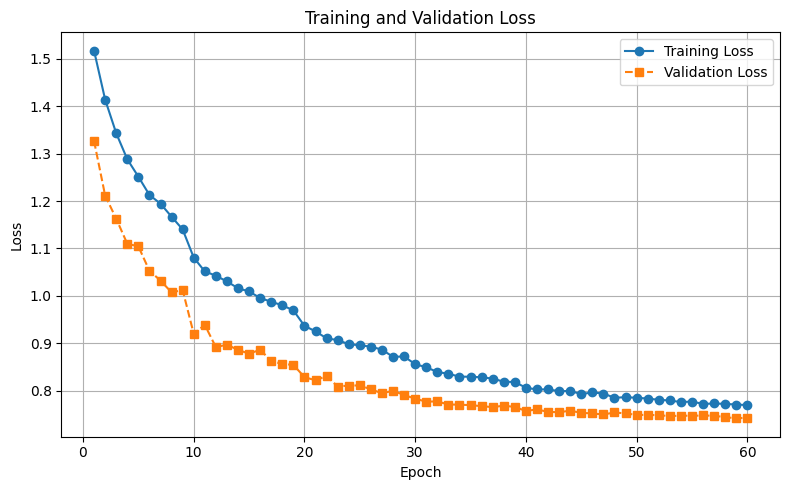

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, totalepochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, traininglosslist, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validationlosslist, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
